In [38]:
import geopandas as gpd
import os
import xarray as xr
import rioxarray as rxr
import rasterio as rio
# import regionmask
from fiona.crs import from_epsg 
from shapely.geometry import Point, Polygon
import h5py as h5
from glob import glob
import json
import dask as da
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from rasterio.warp import reproject, Resampling

import matplotlib 

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)

import warnings
warnings.filterwarnings("ignore")

In [2]:
def gen_extent_from_neon_h5(fi, nid='CPER'):
    
    ds = h5.File(fi, 'r')
    map_info = str(ds['CPER']['Reflectance']['Metadata']['Coordinate_System']['Map_Info'][()])
    epsg = int(ds['CPER']['Reflectance']['Metadata']['Coordinate_System']['EPSG Code'][()])
    data_shape = ds['CPER']['Reflectance']['Reflectance_Data'].shape
    
    # produce the affine transform components
    parts = [p.strip() for p in map_info.split(',')]
    aff = [float(p) for p in parts[1:7]]
    
    px, py, ul_x, ul_y = aff[:4]
    py = -py
    
    num_rows, num_cols, num_bands = data_shape
    
    # produce the points for the extent polygon
    ul = Point(ul_x, ul_y)
    ur = Point((ul_x +  num_cols*px), ul_y)
    ll = Point(ul_x, (ul_y + num_rows*py))
    lr = Point((ul_x + num_cols*px), (ul_y + num_rows*py))

    extent_poly = Polygon((ul, ur, lr, ll, ul))
    
    return extent_poly, epsg

# make function for reading h5 tiles
def read_h5_file(fi, nid='CPER'):
    # Read H5 file
    f = h5.File(fi, "r")
    
    # spectral
    wavelength = f[nid]['Reflectance']['Metadata']['Spectral_Data']['Wavelength'][:]
    fwhm = f[nid]['Reflectance']['Metadata']['Spectral_Data']['FWHM'][:]

    # CRS
    crs_str = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Coordinate_System_String'][()]
    crs_epsg = f[nid]['Reflectance']['Metadata']['Coordinate_System']['EPSG Code'][()]
    crs_mapinfo = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Map_Info'][()]
    crs_proj4 = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Proj4'][()]

    #arr = f[nid]['Radiance']['Radiance_Data'][:]
    arr = da.array.from_array(f[nid]['Reflectance']['Reflectance_Data'], chunks=(256,256,256))
    arr /= float(f[nid]['Reflectance']['Reflectance_Data'].attrs['Scale_Factor'])
    
    mapinfo_list = [a.strip() for a in str(crs_mapinfo).split(',')]
    mapinfo = [float(a) for a in mapinfo_list[1:7]]
    mapinfo
    pix_size = mapinfo[0]
    x = np.arange(mapinfo[2], mapinfo[2] + pix_size*arr.shape[1], pix_size)
    y = np.arange(mapinfo[3], mapinfo[3] - pix_size* arr.shape[0], -pix_size)

    xr_cube = xr.DataArray(arr, {'y': y, 'x': x, 'bands': wavelength}, dims=['y', 'x', 'bands'])
    xr_cube_ma = xr_cube.where(xr_cube != -0.9999) # scaled nodata
    
    # add in CRS assignemnt!!!!!!!!!!!!
    xr_cube_ma = xr_cube_ma.rio.write_crs(int(crs_epsg))
    
    return xr_cube_ma

def resample_h5_spectral(neon_file, weights_file):
    
    nis_ds = read_h5_file(neon_file)
    
    
    with open(weights_file, 'r') as fb:
        weights = json.load(fb)
    
    sample_bands = []
    for k in weights.keys():
        b_weights, b_ids = weights[k]
        sample_band = (nis_ds.isel(bands=b_ids)*np.array(b_weights)).sum(axis=-1)/ np.array(b_weights).sum()
        sample_bands.append(sample_band)
            
    
    sat_ds = xr.concat(sample_bands, dim=list(weights.keys())).rename({'concat_dim':'sat_band'}) # 'sat_band' will be new at dim=0
    
    return sat_ds

def check_valid_pixel_overlap(neon_file, geometry, weights_file):
    
    nis_ds = resample_h5_spectral(neon_file, weights_file)
    #print(nis_ds.spatial_ref)
    
    try:
        sample_clip = nis_ds.rio.clip([geometry])
        sample_band = sample_clip.sat_band.values[0]
        sample_im_clip = sample_clip.sel(sat_band=sample_band)
        
        # count pixels vs total
        total_pixels = sample_im_clip.size
        gt0 = (sample_im_clip > 0.0).sum()
        valid_frac = gt0.values/total_pixels
        
        print(f'valid fraction: {valid_frac}')
        if valid_frac > 0.99:
            return valid_frac
        else:
            print('valid pixels are not above 99% of AOI, returning False')
            return valid_frac
    except Exception as e:
        
        print(e)
        print('not in bounds...')
        return 0.0

In [3]:
#geodataframe for file extents
h5_files = glob('../../NEON_spectrometer-orthorectified-surface-directional-reflectance---flightline-09132020/*.h5')
polys = [gen_extent_from_neon_h5(fi)[0] for fi in h5_files]
desc = [os.path.basename(fi).split('.')[0] for fi in h5_files]
epsg = gen_extent_from_neon_h5(h5_files[0])[1]

fl_gdf = gpd.GeoDataFrame({'geometry': polys, 'filename':desc}, crs=from_epsg(epsg))
fl_gdf.head()

,geometry,filename
0,"POLYGON ((523493.000 4525151.000, 524339.000 4...",NEON_D10_CPER_DP1_20200913_170936_reflectance
1,"POLYGON ((523089.000 4525427.000, 524026.000 4...",NEON_D10_CPER_DP1_20200913_171608_reflectance
2,"POLYGON ((522775.000 4524952.000, 523653.000 4...",NEON_D10_CPER_DP1_20200913_172248_reflectance
3,"POLYGON ((522399.000 4525726.000, 523277.000 4...",NEON_D10_CPER_DP1_20200913_172932_reflectance
4,"POLYGON ((521994.000 4524935.000, 522919.000 4...",NEON_D10_CPER_DP1_20200913_173615_reflectance


In [4]:
temp = read_h5_file(r'../../NEON_spectrometer-orthorectified-surface-directional-reflectance---flightline-09132020\NEON_D10_CPER_DP1_20200913_170936_reflectance.h5')
temp

<xarray.DataArray 'truediv-690ac11cc6581c72f653462b14882b84' (y: 11831, x: 846, bands: 426)>
dask.array<where, shape=(11831, 846, 426), dtype=float64, chunksize=(256, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 4.525e+06 4.525e+06 ... 4.513e+06 4.513e+06
  * x            (x) float64 5.235e+05 5.235e+05 ... 5.243e+05 5.243e+05
  * bands        (bands) float64 381.6 386.6 391.6 ... 2.506e+03 2.511e+03
    spatial_ref  int32 0
Attributes:
    grid_mapping:  spatial_ref

In [5]:
temp[0,0,0].values

array(nan)

In [7]:
# try the resample_match technique for landsat
s2 = '../../OutputsSen2_10m_09132020/SEN2_20200913_lat41lon10435_T13TEF_ORB141_utm13n_vmsk_rad_srefdem.tif'
s2 = '../../OutputsSen2_10m_09132020_AOTL8/SEN2_20200913_lat41lon10435_T13TEF_ORB141_utm13n_vmsk_rad_srefdem.tif' # same AOT as L8
s2 = '../../OutputsSen2_10m_09132020_AOTL8_STDSREF/SEN2_20200913_lat41lon10435_T13TEF_ORB141_utm13n_vmsk_topshad_rad_srefdem_stdsref.tif' # same AOT as L8 and standardized surface reflectance


# s2 = '../../OutputsSen2_10m_09132020_STDSREF/SEN2_20200913_lat41lon10435_T13TEF_ORB141_utm13n_vmsk_topshad_rad_srefdem_stdsref.tif' # standardized SR, DOS method for AOT
# s2 = r'C:\projects\arcsi\S2A_MSIL2A_20200913T174941_N9999_R141_T13TEF_20210301T150241.SAFE\GRANULE\L2A_T13TEF_A027308_20200913T175722\IMG_DATA\s2_stack.vrt' # sen2cor

s2_ds = rxr.open_rasterio(s2)
s2_ds = s2_ds/1000 # arcsi scale factor
s2_weights_file = './spectral_response_cutoff/NIS_weights_S2A.json'

## loop over the geometries and do the groupby method to produce STD and MEAN per satellite pixel

In [26]:
# lists to store results
res_L8_means, res_S2_means, res_L8_stds, res_S2_stds =  [],[],[],[]
L8_arrs, S2_arrs = [],[]

num_fl = 1
for  geom, fi in fl_gdf[['geometry', 'filename']].values[:num_fl]:
    
    fi = os.path.join('../../NEON_spectrometer-orthorectified-surface-directional-reflectance---flightline-09132020', fi + '.h5')
    desc=fi
    print(desc)
    
    # spectral resample to each satellite
    #neon_ds_L8 = resample_h5_spectral(fi, l8_weights_file)
    neon_ds_S2 = resample_h5_spectral(fi, s2_weights_file)
    
    # clip to current AOI
    #neon_ds_L8 = neon_ds_L8.rio.clip([geom], all_touched=True, from_disk=True)
    neon_ds_S2 = neon_ds_S2.rio.clip([geom], all_touched=True, from_disk=True)
    
    # clip landsat and sentinel datasets, add to list
    #L8_arrs.append(landsat_ds.rio.clip([geom], all_touched=True, from_disk=True))
    S2_arrs.append(s2_ds.rio.clip([geom], all_touched=True, from_disk=True))
    
    # group by for mean
#     target_res = 30
#     reduced_L8_mean = (
#         neon_ds_L8
#         .groupby(((neon_ds_L8.x//target_res) + 0.5) * target_res)
#         .mean(dim='x')
#         .groupby(((neon_ds_L8.y//target_res) + 0.5) * target_res)
#         .mean(dim='y'))

    target_res = 10
    reduced_S2_mean = (
        neon_ds_S2
        .groupby(((neon_ds_S2.x//target_res) + 0.5) * target_res)
        .mean(dim='x')
        .groupby(((neon_ds_S2.y//target_res) + 0.5) * target_res)
        .mean(dim='y'))
    
    # group by for STD
#     target_res = 30
#     reduced_L8_std = (
#         neon_ds_L8
#         .groupby(((neon_ds_L8.x//target_res) + 0.5) * target_res)
#         .std(dim='x')
#         .groupby(((neon_ds_L8.y//target_res) + 0.5) * target_res)
#         .std(dim='y'))

    target_res = 10
    reduced_S2_std = (
        neon_ds_S2
        .groupby(((neon_ds_S2.x//target_res) + 0.5) * target_res)
        .std(dim='x')
        .groupby(((neon_ds_S2.y//target_res) + 0.5) * target_res)
        .std(dim='y'))
    
    # append to lists
#     res_L8_means.append(reduced_L8_mean)
    res_S2_means.append(reduced_S2_mean)
#     res_L8_stds.append(reduced_L8_std)
    res_S2_stds.append(reduced_S2_std)


../../NEON_spectrometer-orthorectified-surface-directional-reflectance---flightline-09132020\NEON_D10_CPER_DP1_20200913_170936_reflectance.h5


get samples and corresponding 1-m spectra

In [27]:
nis_ds = read_h5_file(fi)
sat_ds = S2_arrs[0]
res_nis_ds = res_S2_means[0]

In [28]:
x = sat_ds.x.median().values
y = sat_ds.y.median().values
x,y

(array(523915.), array(4519235.))

In [29]:
type(x)

numpy.ndarray

In [30]:
psize=10
cond = (res_nis_ds.x >= x) & (res_nis_ds.x < x+psize) & (res_nis_ds.y >= y) & (res_nis_ds.y < y+psize)
res_nis_sample = res_nis_ds.where(cond, drop=True)

cond = (sat_ds.x >= x) & (sat_ds.x < x+psize) & (sat_ds.y >= y) & (sat_ds.y < y+psize)
sat_sample = sat_ds.where(cond, drop=True)

cond = (nis_ds.x >= x) & (nis_ds.x < x+psize) & (nis_ds.y >= y) & (nis_ds.y < y+psize)
nis_sample = nis_ds.where(cond, drop=True)

res_nis_sample.shape, sat_sample.shape, nis_sample.shape


((13, 1, 1), (10, 1, 1), (10, 10, 426))

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


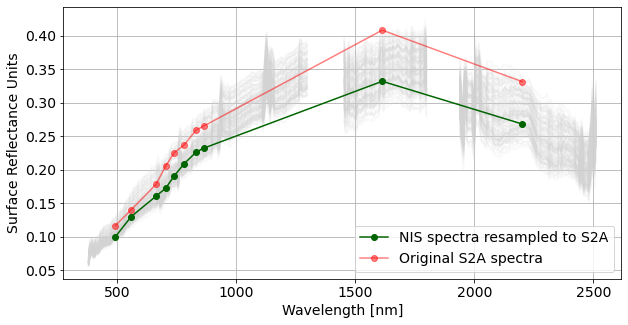

In [39]:
fig, ax = plt.subplots(figsize=(10,5))
s2_wavs = [442.7, 492.4, 559.8, 664.6, 704.1, 740.5,782.8, 832.8, 864.7, 945.1, 1373.5, ]
s2_wavs =        [492.4, 559.8, 664.6, 704.1, 740.5,782.8, 832.8, 864.7,1613.7, 2202.4]

wav_cond1 = (nis_sample.bands >=1300) & (nis_sample.bands < 1450)
wav_cond2 = (nis_sample.bands >=1800) & (nis_sample.bands < 1935)
wav_cond = wav_cond1 | wav_cond2

nis_plot_values = nis_sample.where(~wav_cond)
nis_plot_values = nis_plot_values.values.reshape(nis_sample.shape[0]*nis_sample.shape[1], nis_sample.shape[2]).T
nis_plot_values = np.where(nis_plot_values>1.0, np.nan, nis_plot_values)

ax.plot(nis_sample.bands.values, nis_plot_values, '-', color='lightgrey', alpha=0.14)

# since arcsi doesn't keep the 60m data
s2_nis_vals = res_nis_sample.values.ravel()
idx = [1,2,3,4,5,6,7,8, -2, -1]
s2_nis_vals = s2_nis_vals[idx]
ax.plot(s2_wavs, s2_nis_vals, 'o-', color='darkgreen', label='NIS spectra resampled to S2A')

ax.plot(s2_wavs, sat_sample.values.ravel(), 'o-', color='red', alpha=0.5, label='Original S2A spectra')
ax.grid('on')

plt.xlabel('Wavelength [nm]')
plt.ylabel('Surface Reflectance Units')
plt.legend(loc='lower right')
plt.show()
